<h2> Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
import ta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from alive_progress import alive_bar

import warnings
warnings.filterwarnings("ignore")

<h2> Getting Data

In [3]:
# Set up Alpaca API credentials
api = tradeapi.REST('##########', '#######', base_url='https://paper-api.alpaca.markets')

# Define the stock symbol and time frame
symbol = 'TSLA'  # Tesla stock symbol
timeframe = '1Min'  # 1-minute time frame

# Set the start and end dates for the data
start_date = '2023-01-01'
end_date = '2023-07-30'

# Retrieve the intraday data from Alpaca
barset = api.get_bars(symbol, timeframe, start=start_date, end=end_date).df

# Convert the barset to a Pandas DataFrame
df = pd.DataFrame(barset)
df = df.reset_index()

<h2> Labelling the data

In [4]:
# Define the threshold for labeling
percentage_threshold = 0.0001  # Adjust according to your requirements

# Calculate the percentage change in the 'close' column
df['close_percentage_change'] = df['close'].pct_change()

# Create the target variable based on the percentage change
df['target'] = np.where(df['close_percentage_change'] > percentage_threshold, 1, 0)

# Remove the NaN values resulting from the percentage change calculation
df = df.dropna()

# Convert the 'target' column to integer type
df['target'] = df['target'].astype(int)

<h2> Stationarity Function

In [5]:
def getWeights_FFD(d, thres):
    w, k = [1.], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def fracDiff_FFD(series, d, thres=1e-5):
    w = getWeights_FFD(d, thres)
    width = len(w) - 1
    df = {}

    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()

        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        
        df[name] = df_.copy(deep=True)

    return pd.concat(df, axis=1)

def find_min_d(df, column, max_missing_pct=0.1):
    min_d = 0.0
    min_pvalue = 1.0
    min_missing_pct = 1.0  # Initialize with maximum value

    for d in np.arange(0.0, 1.1, 0.1):
        stationary_data = fracDiff_FFD(df[[column]], d=d)
        missing_pct = stationary_data[column].isna().mean()

        if missing_pct > max_missing_pct:
            continue

        adf_result = adfuller(stationary_data[column].dropna())
        pvalue = adf_result[1]

        if pvalue < .05:
            min_d = d
            min_pvalue = pvalue
            min_missing_pct = missing_pct
            break  # Exit the loop once desired d is found

    return min_d, min_missing_pct

# Function to perform Augmented Dickey-Fuller test and print results
def perform_adf_test(column):
    result = adfuller(column)
    adf_statistic = result[0]
    p_value = result[1]

    print("ADF Statistic for '{}': {}".format(column.name, adf_statistic))
    print("p-value for '{}': {}".format(column.name, p_value))

    if p_value < 0.05:
        print("The '{}' time series is stationary.\n".format(column.name))
    else:
        print("The '{}' time series is non-stationary.\n".format(column.name))

<h2> Feature Engineering

<h3> Momentum Features

In [6]:
def momentum_features(df: pd.core.frame.DataFrame, window: int = 15, window1=7, window2=14, window3=28, weight1=4.0, weight2=2.0, weight3=1.0, pow1: int =1, pow2: int = 30,
                      smooth_window: int = 3, window_slow: int = 26, window_fast: int = 12, window_sign: int = 9, smooth1: int = 3, smooth2: int = 3,
                      lbp: int = 14, fillna: bool = False) -> pd.core.frame.DataFrame:
    
    new_df = df.copy()

    new_df['AwesomeOI'] = ta.momentum.AwesomeOscillatorIndicator(high=df.high, low=df.low, window1=window1, window2=window2, fillna=fillna).awesome_oscillator() 

    new_df['KAMA']= ta.momentum.KAMAIndicator(close=df.close, window=window, pow1=pow1, pow2=pow2, fillna=fillna).kama()

    new_df['POI'] = ta.momentum.PercentagePriceOscillator(close=df.close, window_slow=window_slow, window_fast=window_fast, window_sign=window_sign, fillna=fillna).ppo()

    new_df['PVO'] = ta.momentum.PercentageVolumeOscillator(volume=df.volume, window_slow=window, window_fast=window_fast, window_sign=window_sign, fillna=fillna).pvo()

    new_df['ROC'] = ta.momentum.ROCIndicator(close=df.close, window=window, fillna=fillna).roc()

    new_df['RSI'] = ta.momentum.RSIIndicator(close=df.close, window=window, fillna=fillna).rsi() 

    new_df['SRSI'] = ta.momentum.StochRSIIndicator(close=df.close, window=window, smooth1=smooth1, smooth2=smooth2, fillna=fillna).stochrsi()

    new_df['SOI'] = ta.momentum.StochasticOscillator(high=df.high, low=df.low, close=df.close, window=window, smooth_window=smooth_window, fillna=fillna).stoch()

    new_df['TSI'] = ta.momentum.TSIIndicator(close=df.close, window_slow=window_slow, window_fast=window_fast, fillna=fillna).tsi()

    new_df['UO'] = ta.momentum.UltimateOscillator(high=df.high, low=df.low, close=df.close, window1=window1, window2=window2, window3=window3, weight1=weight1, weight2=weight2, weight3=weight3, fillna=fillna).ultimate_oscillator()

    new_df['WRI'] = ta.momentum.WilliamsRIndicator(high=df.high, low=df.low, close=df.close, lbp=lbp, fillna=fillna).williams_r()

    return new_df

df_with_momentum = momentum_features(df=df, fillna=True)

<h3> Feature Selection with XGBoost

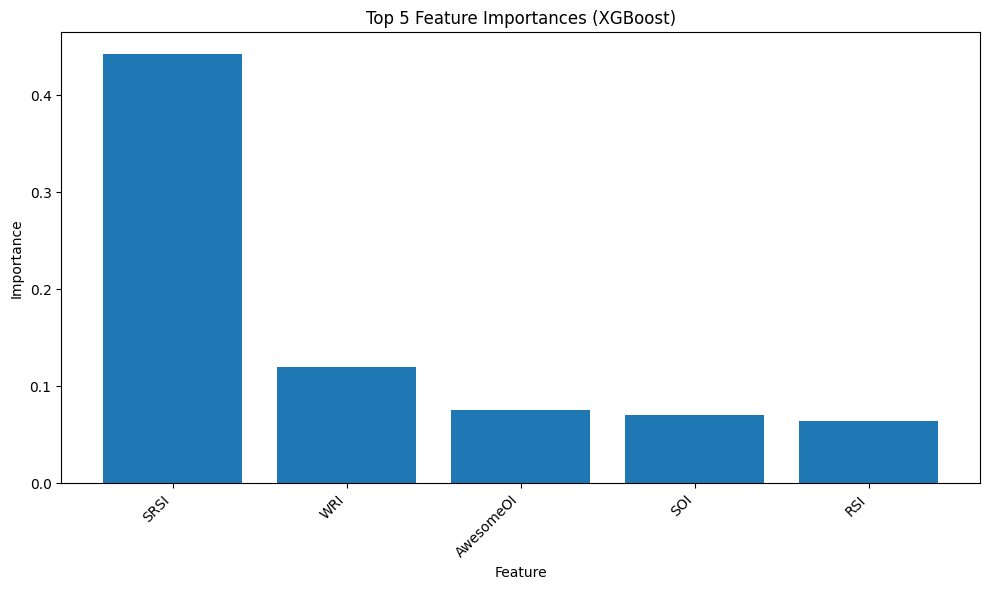

In [7]:
# Separate features and target
X = df_with_momentum.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_momentum['target']

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Train the model on the training data
xgb_model.fit(X, y)

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Select the top N important features (you can change N to your desired number of features)
N = 5
selected_features = feature_importances_df.head(N)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_features['Feature'], selected_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances (XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h4> Sequential Feature Selection

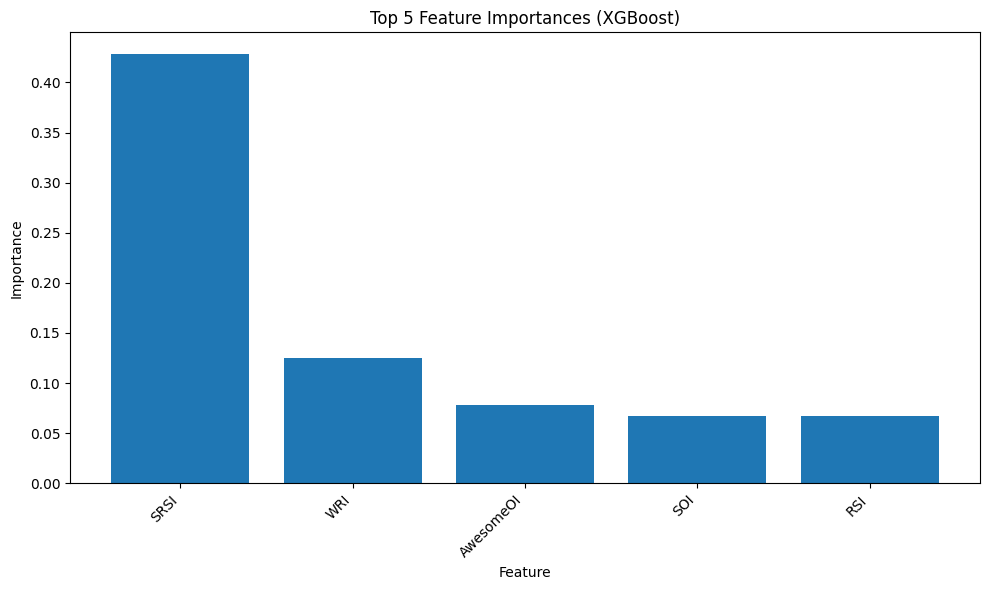

In [8]:
# Separate features and target
X = df_with_momentum.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_momentum['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Select the top N important features (you can change N to your desired number of features)
N = 5
selected_features = feature_importances_df.head(N)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_features['Feature'], selected_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances (XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
chosen_momentum = ['AwesomeOI', 'RSI', 'SRSI', 'UO', 'WRI']
df_chosen_momentum = df_with_momentum[chosen_momentum]

<h4> Testing for Stationarity

In [10]:
# Iterate over each column in the DataFrame
for column in df_chosen_momentum.columns:
    perform_adf_test(df_chosen_momentum[column])

ADF Statistic for 'AwesomeOI': -39.46990133456638
p-value for 'AwesomeOI': 0.0
The 'AwesomeOI' time series is stationary.

ADF Statistic for 'RSI': -58.56865019053498
p-value for 'RSI': 0.0
The 'RSI' time series is stationary.

ADF Statistic for 'SRSI': -55.42989950972142
p-value for 'SRSI': 0.0
The 'SRSI' time series is stationary.

ADF Statistic for 'UO': -38.117738311984944
p-value for 'UO': 0.0
The 'UO' time series is stationary.

ADF Statistic for 'WRI': -67.08197506248487
p-value for 'WRI': 0.0
The 'WRI' time series is stationary.



<h3> Volume Features 

In [11]:
def volume_features(df: pd.core.frame.DataFrame, window: int = 14, fillna: bool = False) -> pd.core.frame.DataFrame:

    new_df = df.copy()

    new_df['AccDistIndexIndicator'] = ta.volume.AccDistIndexIndicator(high=df.high, low=df.low, close=df.close, volume=df.volume, fillna=fillna).acc_dist_index()

    new_df['ChaikinMoneyFlowIndicator'] = ta.volume.ChaikinMoneyFlowIndicator(high=df.high, low=df.low, close=df.close, volume=df.volume, window=window, fillna=fillna).chaikin_money_flow()

    new_df['EaseOfMovementIndicator'] = ta.volume.EaseOfMovementIndicator(high=df.high, low=df.low, volume=df.volume, window=window, fillna=fillna).ease_of_movement()

    new_df['ForceIndexIndicator'] = ta.volume.ForceIndexIndicator(close=df.close, volume=df.volume, window=window, fillna=fillna).force_index()

    new_df['MFIIndicator'] = ta.volume.MFIIndicator(high=df.high, low=df.low, close=df.close, volume=df.volume, window=window, fillna=fillna).money_flow_index()

    new_df['NegativeVolumeIndexIndicator'] = ta.volume.NegativeVolumeIndexIndicator(close=df.close, volume=df.volume, fillna=fillna).negative_volume_index()

    new_df['OnBalanceVolumeIndicator'] = ta.volume.OnBalanceVolumeIndicator(close=df.close, volume=df.volume, fillna=fillna).on_balance_volume()

    new_df['VolumePriceTrendIndicator'] = ta.volume.VolumePriceTrendIndicator(close=df.close, volume=df.volume, fillna=fillna).volume_price_trend()

    new_df['VolumeWeightedAveragePrice'] = ta.volume.VolumeWeightedAveragePrice(high=df.high, low=df.low, close=df.close, volume=df.volume, window=window, fillna=fillna).volume_weighted_average_price() 

    return new_df

df_with_volume = volume_features(df=df, fillna=True)

<h4> Feature Selecrion with XGBoost

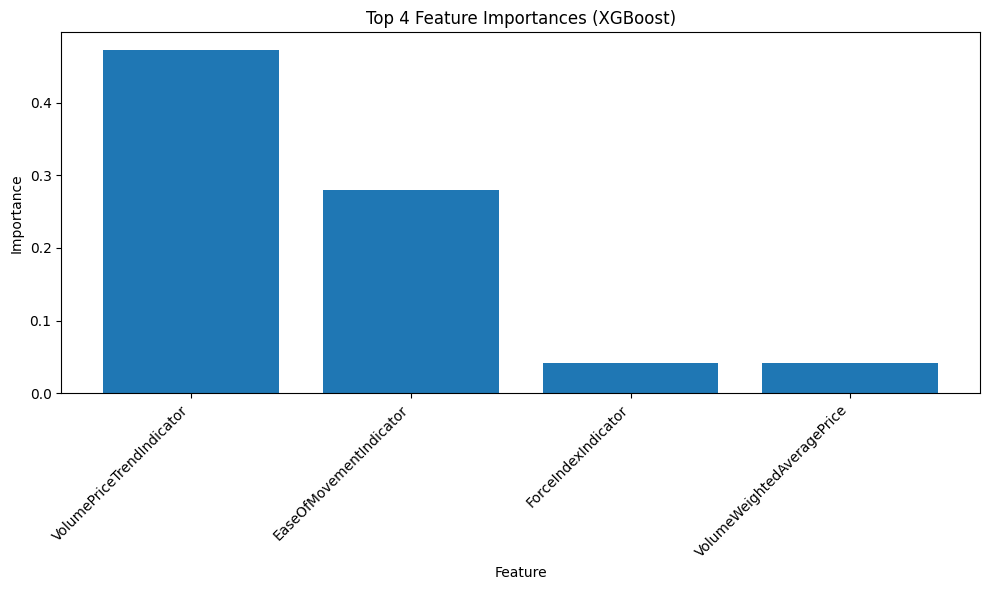

In [12]:
# Separate features and target
X = df_with_volume.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_volume['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Select the top N important features (you can change N to your desired number of features)
N = 4
selected_features = feature_importances_df.head(N)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_features['Feature'], selected_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 4 Feature Importances (XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h4> Feature Selection with Sequential Featue 


[2023-08-29 16:29:53] Features: 1/4 -- score: 0.7276297396028081
[2023-08-29 16:30:19] Features: 2/4 -- score: 0.7416419162448076
[2023-08-29 16:30:47] Features: 3/4 -- score: 0.7432446424088154
[2023-08-29 16:31:12] Features: 4/4 -- score: 0.7425698119071247

Accuracy on the test set: 0.7463822448826573


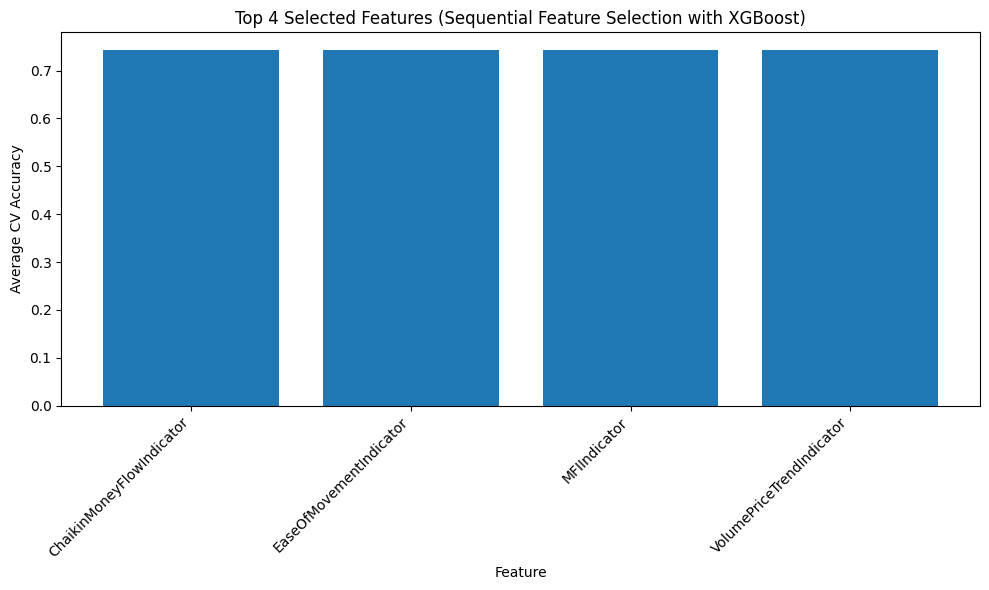

In [13]:
# Separate features and target
X = df_with_volume.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_volume['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(xgb_model,
                                k_features=4,  
                                forward=True,  # Forward selection (you can also try backward selection)
                                floating=False,
                                verbose=2,
                                scoring='accuracy',
                                cv=3)

# Perform Sequential Feature Selection
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = sfs.k_feature_idx_

# Get the selected feature names
# Get the names of the selected features
selected_feature_names = list(X.columns[list(selected_feature_indices)])

# Train the XGBoost model on the selected features
xgb_model.fit(X_train.iloc[:, list(selected_feature_indices)], y_train)

# Evaluate the model on the test set
accuracy = xgb_model.score(X_test.iloc[:, list(selected_feature_indices)], y_test)
print("Accuracy on the test set:", accuracy)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_feature_names, sfs.k_score_)
plt.xlabel('Feature')
plt.ylabel('Average CV Accuracy')
plt.title('Top 4 Selected Features (Sequential Feature Selection with XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
chosen_volume = ['EaseOfMovementIndicator', 'MFIIndicator', 'OnBalanceVolumeIndicator', 'VolumePriceTrendIndicator']
df_chosen_volume = df_with_volume[chosen_volume]

In [15]:
# Iterate over each column in the DataFrame
for column in df_chosen_volume.columns:
    perform_adf_test(df_chosen_volume[column])

ADF Statistic for 'EaseOfMovementIndicator': -89.00092940012482
p-value for 'EaseOfMovementIndicator': 0.0
The 'EaseOfMovementIndicator' time series is stationary.

ADF Statistic for 'MFIIndicator': -38.6039144845518
p-value for 'MFIIndicator': 0.0
The 'MFIIndicator' time series is stationary.

ADF Statistic for 'OnBalanceVolumeIndicator': -1.4950706404183347
p-value for 'OnBalanceVolumeIndicator': 0.5359483979693115
The 'OnBalanceVolumeIndicator' time series is non-stationary.

ADF Statistic for 'VolumePriceTrendIndicator': -39.69352391431176
p-value for 'VolumePriceTrendIndicator': 0.0
The 'VolumePriceTrendIndicator' time series is stationary.



In [16]:
find_min_d(df_chosen_volume, 'OnBalanceVolumeIndicator')

(0.6000000000000001, 0.0)

In [17]:
result = fracDiff_FFD(df_chosen_volume[['OnBalanceVolumeIndicator']], d=0.6000000000000001)
# Rename the column of the result so it doesn't clash with the original column
result = result.rename(columns={'OnBalanceVolumeIndicator': 'OnBalanceVolumeIndicator_FFD'})

# Join the original dataframe with the result
df_chosen_volume = df_chosen_volume.join(result, how='outer')

<h3> Volatility Feautures

In [18]:
def volatility_features(df: pd.core.frame.DataFrame, window: int = 14, window_dev: int = 2, offset: int = 0, window_atr: int = 10, original_version: bool = True, multiplier: int = 2, fillna: bool = False) -> pd.core.frame.DataFrame:
    
    new_df = df.copy()
    
    new_df['AverageTrueRange'] = ta.volatility.AverageTrueRange(high=df.high, low=df.low, close=df.close, window=window, fillna=fillna).average_true_range()

    new_df['BollingerBands'] = ta.volatility.BollingerBands(close=df.close, window=window, window_dev=window_dev, fillna=fillna).bollinger_hband()

    new_df['DonchianChannel'] = ta.volatility.DonchianChannel(high=df.high, low=df.low, close=df.close, window=window, offset=offset, fillna=fillna).donchian_channel_hband()

    new_df['KeltnerChannel'] = ta.volatility.KeltnerChannel(high=df.high, low=df.low, close=df.close, window=window, window_atr=window_atr, fillna=fillna, original_version=original_version, multiplier=multiplier).keltner_channel_hband()

    new_df['UlcerIndex'] = ta.volatility.UlcerIndex(close=df.close, window=window, fillna=fillna).ulcer_index()

    return new_df

df_with_volatility = volatility_features(df, fillna=True)

<h4>Feature Selection with XGboost

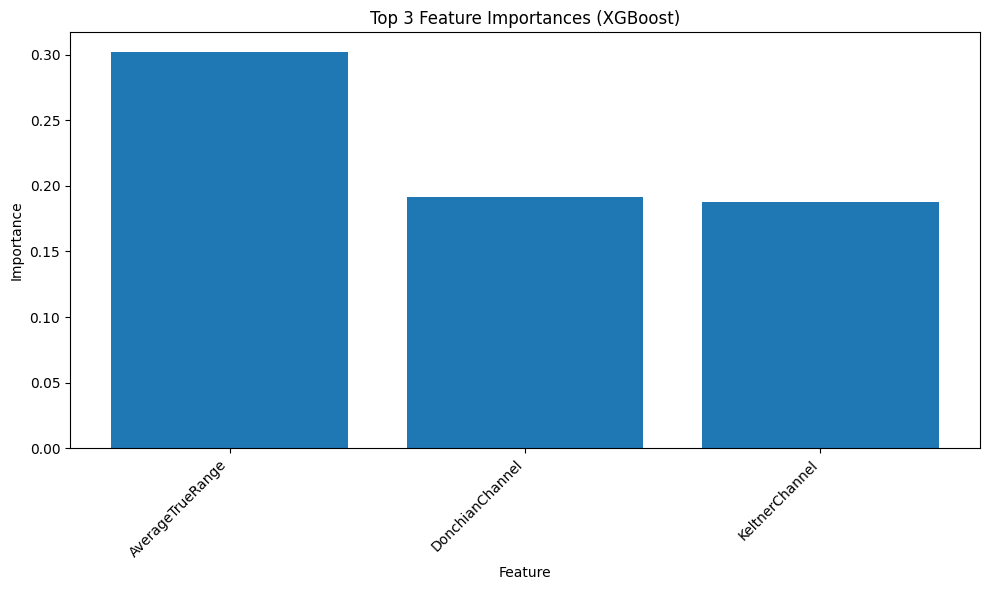

In [19]:
# Separate features and target
X = df_with_volatility.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_volatility['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Select the top N important features (you can change N to your desired number of features)
N = 3
selected_features = feature_importances_df.head(N)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_features['Feature'], selected_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 3 Feature Importances (XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h4> Feature Selection with Sequential Feature


[2023-08-29 16:49:22] Features: 1/3 -- score: 0.5748549757918365
[2023-08-29 16:49:35] Features: 2/3 -- score: 0.5746393785356197
[2023-08-29 16:49:46] Features: 3/3 -- score: 0.572539865571467

Accuracy on the test set: 0.5759541126190297


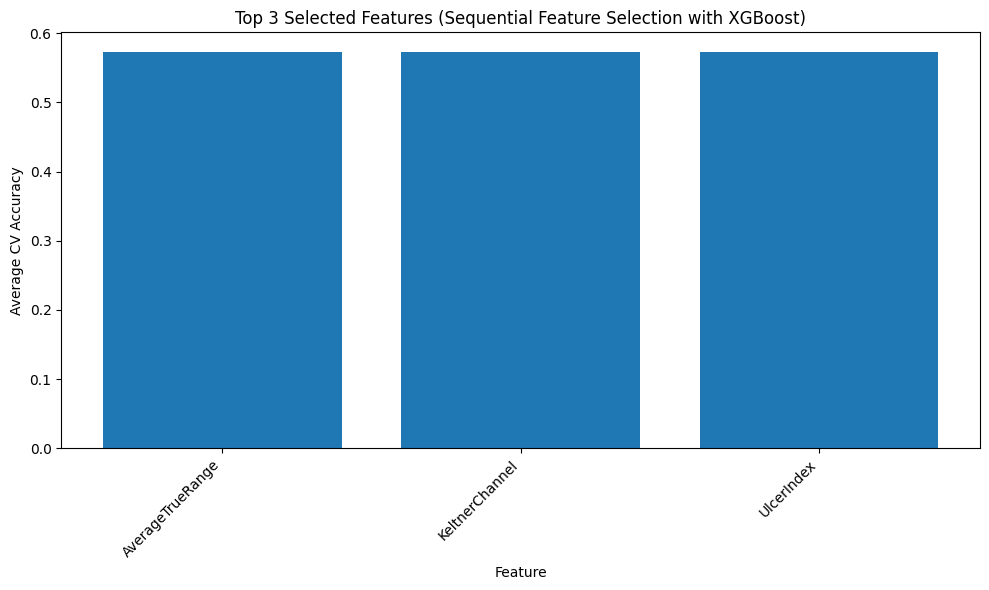

In [20]:
# Separate features and target
X = df_with_volatility.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_volatility['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(xgb_model,
                                k_features=3,  
                                forward=True,  # Forward selection (you can also try backward selection)
                                floating=False,
                                verbose=2,
                                scoring='accuracy',
                                cv=3)

# Perform Sequential Feature Selection
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = sfs.k_feature_idx_

# Get the selected feature names
# Get the names of the selected features
selected_feature_names = list(X.columns[list(selected_feature_indices)])

# Train the XGBoost model on the selected features
xgb_model.fit(X_train.iloc[:, list(selected_feature_indices)], y_train)

# Evaluate the model on the test set
accuracy = xgb_model.score(X_test.iloc[:, list(selected_feature_indices)], y_test)
print("Accuracy on the test set:", accuracy)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_feature_names, sfs.k_score_)
plt.xlabel('Feature')
plt.ylabel('Average CV Accuracy')
plt.title('Top 3 Selected Features (Sequential Feature Selection with XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
chosen_volatility = ['AverageTrueRange', 'KeltnerChannel', 'UlcerIndex']
df_chosen_volatility = df_with_volatility[chosen_volatility]

In [22]:
# Iterate over each column in the DataFrame
for column in df_chosen_volatility.columns:
    perform_adf_test(df_chosen_volatility[column])

ADF Statistic for 'AverageTrueRange': -19.034695164928824
p-value for 'AverageTrueRange': 0.0
The 'AverageTrueRange' time series is stationary.

ADF Statistic for 'KeltnerChannel': -1.1868137088917259
p-value for 'KeltnerChannel': 0.679242244413833
The 'KeltnerChannel' time series is non-stationary.

ADF Statistic for 'UlcerIndex': -26.45139770840199
p-value for 'UlcerIndex': 0.0
The 'UlcerIndex' time series is stationary.



In [23]:
find_min_d(df_chosen_volatility, 'KeltnerChannel')

(0.30000000000000004, 0.0)

In [24]:
result = fracDiff_FFD(df_chosen_volatility[['KeltnerChannel']], d=0.30000000000000004)
result = result.rename(columns={'KeltnerChannel': 'KeltnerChannel_DFF'})
df_chosen_volatility = df_chosen_volatility.join(result, how='outer')

<h3> Trend Features

In [25]:
def trend_features(df: pd.core.frame.DataFrame, window: int = 14, constant: float = 0.015, window1: int = 9, window2: int = 26, window3: int = 52, visual: bool = False, roc1: int = 10, roc2: int = 15, roc3: int = 20, roc4: int = 30, window4: int = 15, nsig: int = 9, window_slow: int = 26, window_fast: int = 12, window_sign: int = 9, step: float = 0.02, max_step: float = 0.2, cycle: int = 10, smooth1: int = 3, smooth2: int = 3, fillna: bool = False) -> pd.core.frame.DataFrame:

    new_df = df.copy()

    new_df['ADXIndicator'] = ta.trend.ADXIndicator(high=df.high, low=df.low, close=df.close, window=window, fillna=fillna).adx()

    new_df['AroonIndicator'] = ta.trend.AroonIndicator(close=df.close, window=window, fillna=fillna).aroon_down()

    new_df['CCIIndicator'] = ta.trend.CCIIndicator(high=df.high, low=df.low, close=df.close, window=window, constant=constant, fillna=fillna).cci()

    new_df['DPOIndicator'] = ta.trend.DPOIndicator(close=df.close, window=window, fillna=fillna).dpo() 

    new_df['EMAIndicator'] = ta.trend.EMAIndicator(close=df.close, window=window, fillna=fillna).ema_indicator()

    new_df['IchimokuIndicator'] = ta.trend.IchimokuIndicator(high=df.high, low=df.low, window1=window1, window2=window2, window3=window3, visual=visual, fillna=fillna).ichimoku_a() 

    new_df['KSTIndicator'] = ta.trend.KSTIndicator(close=df.close, roc1=roc1, roc2=roc2, roc3=roc3, roc4=roc4, window1=window1, window2=window2, window3=window3, window4=window4, nsig=nsig, fillna=fillna).kst()

    new_df['MACD'] = ta.trend.MACD(close=df.close, window_slow=window_slow, window_fast=window_fast, window_sign=window_sign, fillna=fillna).macd()

    new_df['MassIndex'] = ta.trend.MassIndex(high=df.high, low=df.low, window_fast=window_fast, window_slow=window_slow, fillna=fillna).mass_index() 

    new_df['PSARIndicator'] = ta.trend.PSARIndicator(high=df.high, low=df.low, close=df.close, step=step, max_step=max_step, fillna=fillna).psar()

    new_df['SMAIndicator'] = ta.trend.SMAIndicator(close=df.close, window=window, fillna=fillna).sma_indicator()

    new_df['STCIndicator'] = ta.trend.STCIndicator(close=df.close, window_slow=window_slow, window_fast=window_fast, cycle=cycle, smooth1=smooth1, smooth2=smooth2, fillna=fillna).stc()

    new_df['TRIXIndicatorr'] = ta.trend.TRIXIndicator(close=df.close, window=window, fillna=fillna).trix() 

    new_df['VortexIndicator'] = ta.trend.VortexIndicator(high=df.high, low=df.low, close=df.close, window=window, fillna=fillna).vortex_indicator_diff()

    new_df['WMAIndicator'] = ta.trend.WMAIndicator(close=df.close, window=window, fillna=fillna).wma()

    return new_df

In [26]:
df_with_trend = trend_features(df, fillna=True)

<h4> Feature Selection with XGboost

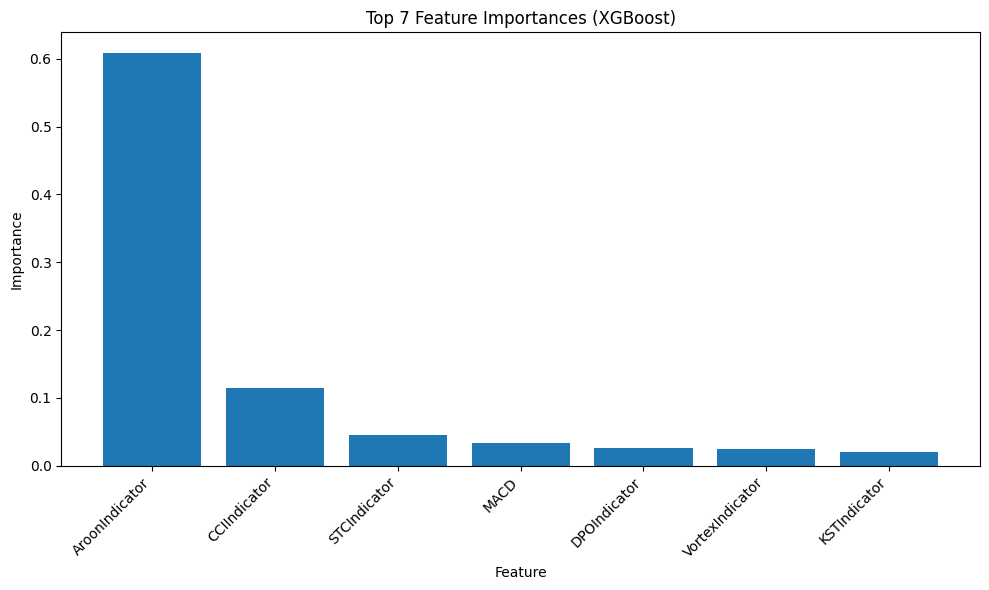

In [27]:
# Separate features and target
X = df_with_trend.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_trend['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort features by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Select the top N important features (you can change N to your desired number of features)
N = 7
selected_features = feature_importances_df.head(N)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_features['Feature'], selected_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 7 Feature Importances (XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h4> Sequential Feature Selection


[2023-08-29 17:01:42] Features: 1/7 -- score: 0.6372864051810048
[2023-08-29 17:02:28] Features: 2/7 -- score: 0.7022578787158463
[2023-08-29 17:03:14] Features: 3/7 -- score: 0.7112181518002929
[2023-08-29 17:04:02] Features: 4/7 -- score: 0.722802776031962
[2023-08-29 17:04:51] Features: 5/7 -- score: 0.7253990241425633
[2023-08-29 17:05:41] Features: 6/7 -- score: 0.7268705346335159
[2023-08-29 17:06:26] Features: 7/7 -- score: 0.7272079552869162

Accuracy on the test set: 0.7314613481292644


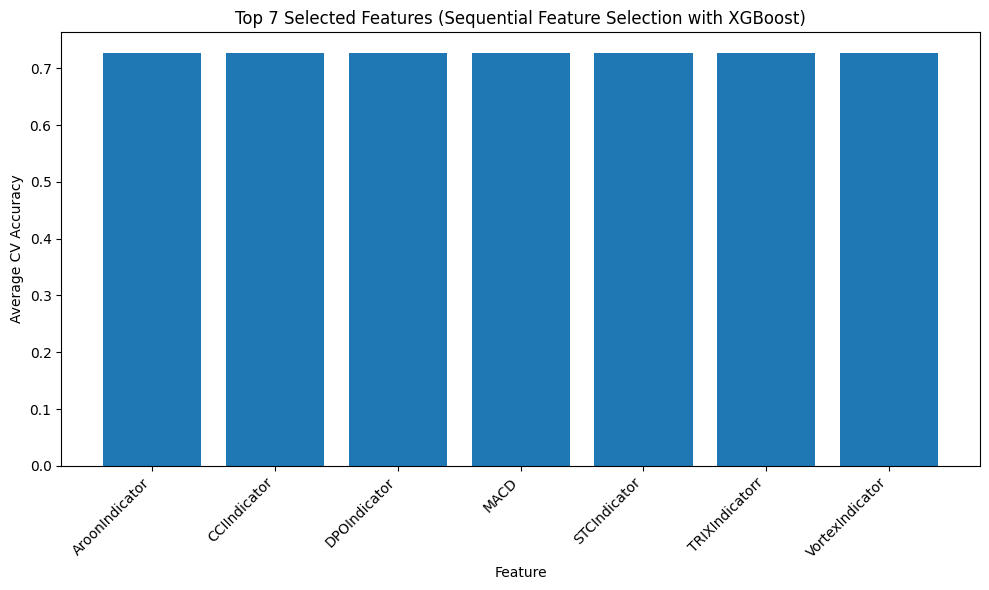

In [28]:
# Separate features and target
X = df_with_trend.drop(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'close_percentage_change', 'target'], axis=1)
y = df_with_trend['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(xgb_model,
                                k_features=7,  
                                forward=True,  # Forward selection (you can also try backward selection)
                                floating=False,
                                verbose=2,
                                scoring='accuracy',
                                cv=3)

# Perform Sequential Feature Selection
sfs = sfs.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices = sfs.k_feature_idx_

# Get the selected feature names
# Get the names of the selected features
selected_feature_names = list(X.columns[list(selected_feature_indices)])

# Train the XGBoost model on the selected features
xgb_model.fit(X_train.iloc[:, list(selected_feature_indices)], y_train)

# Evaluate the model on the test set
accuracy = xgb_model.score(X_test.iloc[:, list(selected_feature_indices)], y_test)
print("Accuracy on the test set:", accuracy)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(selected_feature_names, sfs.k_score_)
plt.xlabel('Feature')
plt.ylabel('Average CV Accuracy')
plt.title('Top 7 Selected Features (Sequential Feature Selection with XGBoost)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
chosen_trend = ['AroonIndicator', 'CCIIndicator', 'DPOIndicator', 'MACD', 'STCIndicator', 'TRIXIndicatorr', 'VortexIndicator']
df_chosen_trend = df_with_trend[chosen_trend]

In [30]:
# Iterate over each column in the DataFrame
for column in df_chosen_trend.columns:
    perform_adf_test(df_chosen_trend[column])

ADF Statistic for 'AroonIndicator': -75.46922572722693
p-value for 'AroonIndicator': 0.0
The 'AroonIndicator' time series is stationary.

ADF Statistic for 'CCIIndicator': -58.07797808016584
p-value for 'CCIIndicator': 0.0
The 'CCIIndicator' time series is stationary.

ADF Statistic for 'DPOIndicator': -89.82841254957566
p-value for 'DPOIndicator': 0.0
The 'DPOIndicator' time series is stationary.

ADF Statistic for 'MACD': -45.62237649739148
p-value for 'MACD': 0.0
The 'MACD' time series is stationary.

ADF Statistic for 'STCIndicator': -54.05341309762267
p-value for 'STCIndicator': 0.0
The 'STCIndicator' time series is stationary.

ADF Statistic for 'TRIXIndicatorr': -34.75563764925493
p-value for 'TRIXIndicatorr': 0.0
The 'TRIXIndicatorr' time series is stationary.

ADF Statistic for 'VortexIndicator': -38.81051868841
p-value for 'VortexIndicator': 0.0
The 'VortexIndicator' time series is stationary.



<h3> Combining all Data Frames

In [31]:
# List of all dataframes to be combined with df
dfs_to_add = [df_chosen_momentum, df_chosen_trend, df_chosen_volume, df_chosen_volatility]

# For each dataframe, add columns to df that aren't already present in df
for df_to_add in dfs_to_add:
    # Get columns that are not in df
    new_columns = df_to_add.columns.difference(df.columns)
    
    # Add those columns to df
    df = pd.concat([df, df_to_add[new_columns]], axis=1)

<h3> Time Features

In [32]:
# Extracting features
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['is_weekend'] = (df['timestamp'].dt.weekday >= 5).astype(int)

In [33]:
# Short-term EMA
df['EMA_5'] = df['close'].ewm(span=5, adjust=False).mean()
df['EMA_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['EMA_15'] = df['close'].ewm(span=15, adjust=False).mean()

# Medium-term EMA
df['EMA_30'] = df['close'].ewm(span=30, adjust=False).mean()
df['EMA_60'] = df['close'].ewm(span=60, adjust=False).mean()
df['EMA_90'] = df['close'].ewm(span=90, adjust=False).mean()

# Long-term EMA
df['EMA_360'] = df['close'].ewm(span=360, adjust=False).mean()

In [34]:
# 1. Rolling Volatility
df['rolling_vol_15'] = df['close'].rolling(window=15).std()

# 2. Bollinger Bands
df['rolling_mean_20'] = df['close'].rolling(window=20).mean()
df['bollinger_upper'] = df['rolling_mean_20'] + (df['close'].rolling(window=20).std() * 2)
df['bollinger_lower'] = df['rolling_mean_20'] - (df['close'].rolling(window=20).std() * 2)

# 3. Rate of Change
df['roc_15'] = ((df['close'] - df['close'].shift(15)) / df['close'].shift(15)) * 100

# 4. Rolling Skewness and Kurtosis
df['rolling_skew_30'] = df['close'].rolling(window=30).skew()
df['rolling_kurt_30'] = df['close'].rolling(window=30).kurt()

# 5. Rolling Quantiles
df['rolling_quantile_25_30'] = df['close'].rolling(window=30).quantile(0.25)
df['rolling_quantile_75_30'] = df['close'].rolling(window=30).quantile(0.75)

# 6. Rolling Momentum
df['rolling_momentum_5'] = df['close'] - df['close'].shift(5)

# 7. Rolling Correlation between Close and Volume
df['rolling_corr_close_volume_60'] = df['close'].rolling(window=60).corr(df['volume'])

# 8. Exponential Rolling Statistics
df['exp_rolling_mean_30'] = df['close'].ewm(span=30, adjust=False).mean()
df['exp_rolling_std_60'] = df['close'].ewm(span=60, adjust=False).std()

# 9. Longer rolling features to capture daily patterns (since there are 1440 minutes in a day)
df['rolling_mean_1440'] = df['close'].rolling(window=1440).mean()
df['rolling_vol_1440'] = df['close'].rolling(window=1440).std()

# 10. Exponential rolling statistics for daily patterns
df['exp_rolling_mean_720'] = df['close'].ewm(span=720, adjust=False).mean()
df['exp_rolling_std_1440'] = df['close'].ewm(span=1440, adjust=False).std()

<h3> Stationarity of 'Close'

In [35]:
find_min_d(df, 'close')

(0.30000000000000004, 0.0)

In [36]:
result = fracDiff_FFD(df[['close']], d=0.30000000000000004)
result = result.rename(columns={'close': 'close_DFF'})
df = df.join(result, how='outer')

<h3> Shifting Features

In [37]:
# Create a copy of the dataframe
shifted_df = df.copy()

# List of features to be lagged
to_be_shifted = [
    'close_DFF', 'volume', 'trade_count', 'vwap', 'AwesomeOI', 'RSI', 'SRSI',
    'UO', 'WRI', 'AroonIndicator', 'CCIIndicator', 'DPOIndicator', 'MACD',
    'STCIndicator', 'TRIXIndicatorr', 'VortexIndicator', 'EaseOfMovementIndicator',
    'MFIIndicator', 'OnBalanceVolumeIndicator_FFD', 'VolumePriceTrendIndicator',
    'AverageTrueRange', 'KeltnerChannel_DFF', 'UlcerIndex',
    'rolling_vol_15', 'rolling_mean_20', 'bollinger_upper', 'bollinger_lower', 
    'roc_15', 'rolling_skew_30', 'rolling_kurt_30', 'rolling_quantile_25_30',
    'rolling_quantile_75_30', 'rolling_momentum_5', 'rolling_corr_close_volume_60',
    'exp_rolling_mean_30', 'exp_rolling_std_60', 'rolling_mean_1440',
    'rolling_vol_1440', 'exp_rolling_mean_720', 'exp_rolling_std_1440'
]

# Define the number of lags
max_lags = 3 

# Shift the columns with alive-progress bar and emoji spinner
with alive_bar(len(to_be_shifted) * max_lags, spinner='arrows') as bar:
    for column in to_be_shifted:
        for lag in range(1, max_lags + 1):
            shifted_df[f"{column}_lag{lag}"] = shifted_df[column].shift(lag)
            bar()  # update the progress bar after processing each lag for a column

# Drop the initial rows with NaN values due to shifting
shifted_df.dropna(inplace=True)

# Drop the original columns that were shifted
shifted_df.drop(columns=to_be_shifted, inplace=True)

|████████████████████████████████████████| 120/120 [100%] in 0.0s (4329.62/s) 


In [38]:
shifted_df.to_csv('TeslaData.csv', index=False)